In [388]:
import pickle
import matplotlib.pyplot as pl

red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'
colors = [red, green, blue, yellow, darkblue]

In [567]:
output_dir = '/Users/tgordon/research/exomoons/JexoSim/output/'
result = pickle.load(open(output_dir + 'OOT_SNR_NIRSpec_BOTS_G140M_F100LP_Kepler-22 b_2020_11_04_1454_50.pickle', 'rb'))

wl = result['noise_dic']['All noise']['wl']
means = result['noise_dic']['All noise']['signal_mean_stack']
stds = result['noise_dic']['All noise']['signal_std_stack']

t = np.arange(0, 20*60*60, 8.118) #2.01488 
t / (60*60)

array([0.0000000e+00, 2.2550000e-03, 4.5100000e-03, ..., 1.9995085e+01,
       1.9997340e+01, 1.9999595e+01])

In [639]:
# simulate a time-series representing the covering fraction of the cold photosphere component 

import celerite2
from celerite2 import terms

S0 = 2e-11
term = terms.SHOTerm(S0=S0, w0=886, Q=1/np.sqrt(2))
gp = celerite2.GaussianProcess(term, mean=0.0)
gp.compute(t/(60*60*24), yerr = 0)
fk = (gp.dot_tril(np.random.randn(len(t))) + 1)

In [640]:
import sys
sys.path.append('../../notebooks/')
import generate_noise
import imp
imp.reload(generate_noise)

factors, data, wl = generate_noise.variability_factors(fk, wl, cold_temp=5500, hot_temp=5600, effective_temp=5500, spec_path='../../JexoSim/archive')

../../notebooks/generate_noise.py:40: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  flux_hot_kep = quad(int_hot_kep, np.min(kep_band[0])/1e3, np.max(kep_band[0])/1e3)
../../notebooks/generate_noise.py:41: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 

In [641]:
shot_noise = np.random.randn(len(wl), len(t))*stds[:, None]
noisy_lc = means[None, :]*factors.T + shot_noise.T

In [642]:
60 / np.diff(t)

array([7.390983, 7.390983, 7.390983, ..., 7.390983, 7.390983, 7.390983])

In [643]:
(np.sqrt(np.sum(stds ** 2)) / np.sum(means)) / np.sqrt(7.4)

4.629838112112551e-05

In [644]:
# equal white-noise bins

nbins = 3
total_wn = np.sqrt(np.sum(stds ** 2))
wn_per_bin = total_wn / np.sqrt(nbins)

inds = [0]
j = 0
for i in range(nbins):
    sum_wn_squared = 0
    sum_mean = 0
    while (np.sqrt(sum_wn_squared) < wn_per_bin) & (j < len(stds)):
        sum_wn_squared += stds[j] ** 2
        j += 1
    inds.append(j)

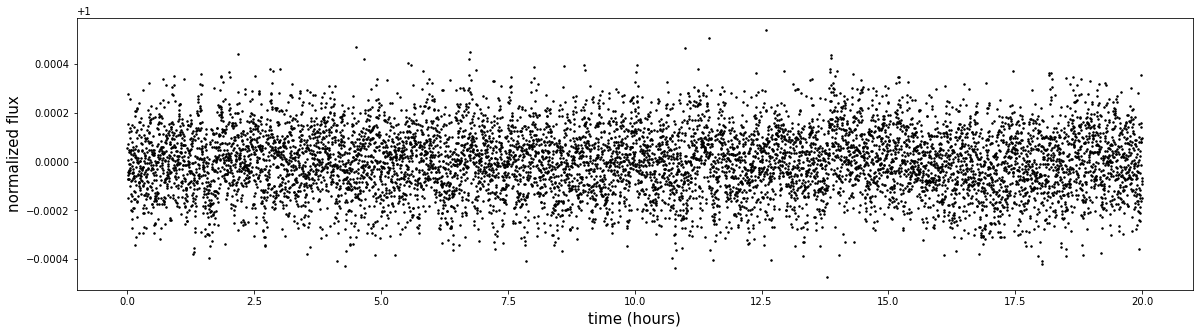

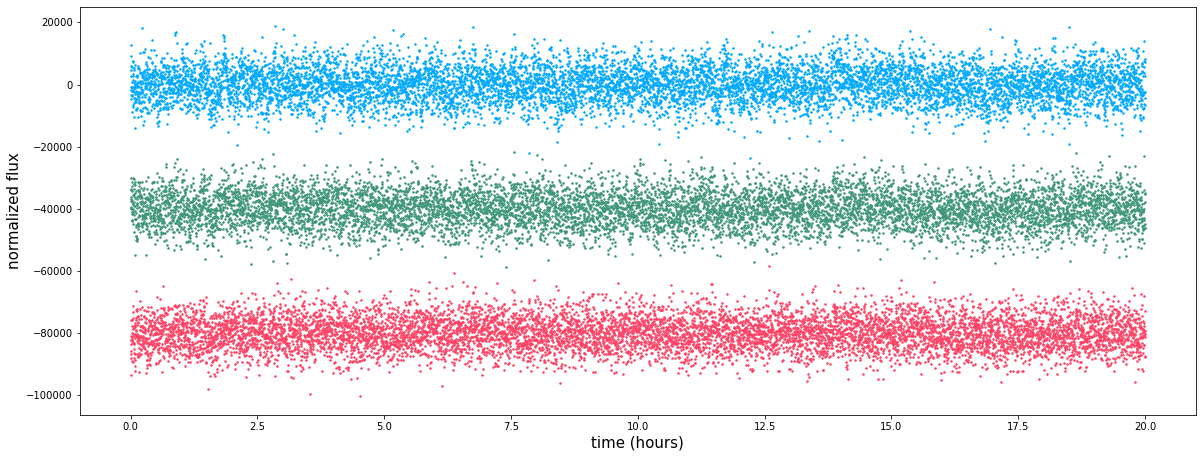

In [645]:
pl.figure(figsize=(20, 5))
monochrome = np.sum(noisy_lc, axis=1)

lcs = np.zeros((len(t), len(inds)-1))
for i in range(len(inds)-1):
    lcs[:, i] = np.sum(noisy_lc[:, inds[i]:inds[i+1]], axis=1)
pl.plot(t/(60*60), monochrome/np.mean(monochrome), 'k.', alpha=1, ms=3)
pl.ylabel("normalized flux", fontsize=15)
pl.xlabel("time (hours)", fontsize=15)
pl.savefig("/Users/tgordon/Desktop/monoflux.pdf")

pl.figure(figsize=(20, 7.5))
for i in range(len(inds)-1):
    pl.plot(t/(60*60), lcs[:, i] - np.mean(lcs[:, i]) - 40000 * i, '.', alpha=1, color=colors[2-i], ms=3)
pl.ylabel("normalized flux", fontsize=15)
pl.xlabel("time (hours)", fontsize=15)
pl.savefig("/Users/tgordon/Desktop/multiflux.pdf")

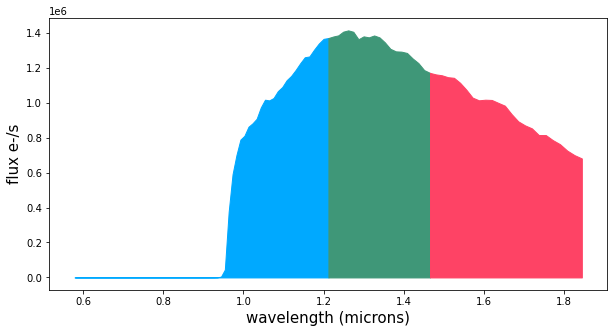

In [646]:
pl.figure(figsize=(10, 5))

for i in range(len(inds)-1):
    pl.fill_between(wl[inds[i]:inds[i+1]+1], means[0:][inds[i]:inds[i+1]+1], color=colors[2-i])
    
pl.xlabel('wavelength (microns)', fontsize=15)
pl.ylabel('flux e-/s', fontsize=15)
pl.savefig("/Users/tgordon/Desktop/spec.pdf")

In [659]:
import exoplanet as xo
orbit = xo.orbits.KeplerianOrbit(period=5.0*60*60)
u = [0.3, 0.2]
planet = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=0.0203, t=t/(60*60) - 10, texp=0.02)
    .eval()
).T[0]
moon = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=0.00487 , t=t/(60*60) - 5, texp=0.02)
    .eval()
).T[0]

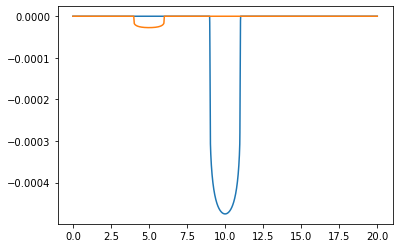

In [660]:
pl.plot(t/(60*60), planet)
pl.plot(t/(60*60), moon)

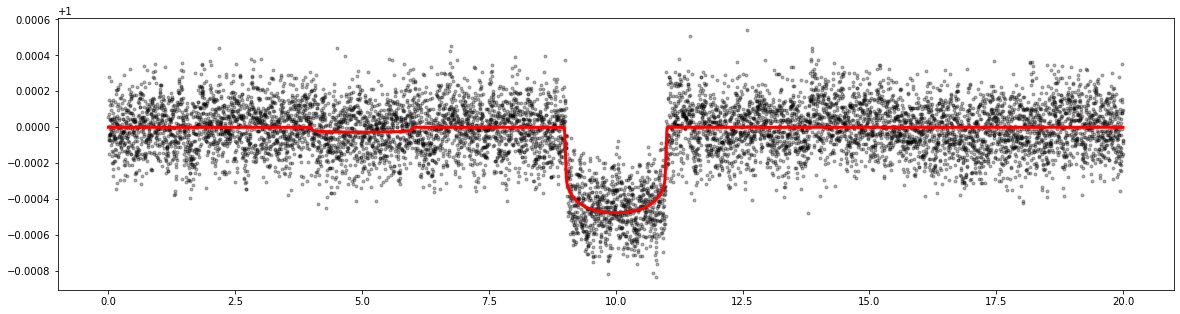

In [661]:
pl.figure(figsize=(20, 5))
pl.plot(t/(60*60), monochrome/np.mean(monochrome) + moon + planet, 'k.', alpha=0.3)
pl.plot(t/(60*60), moon+1+planet, linewidth=3, color='r')

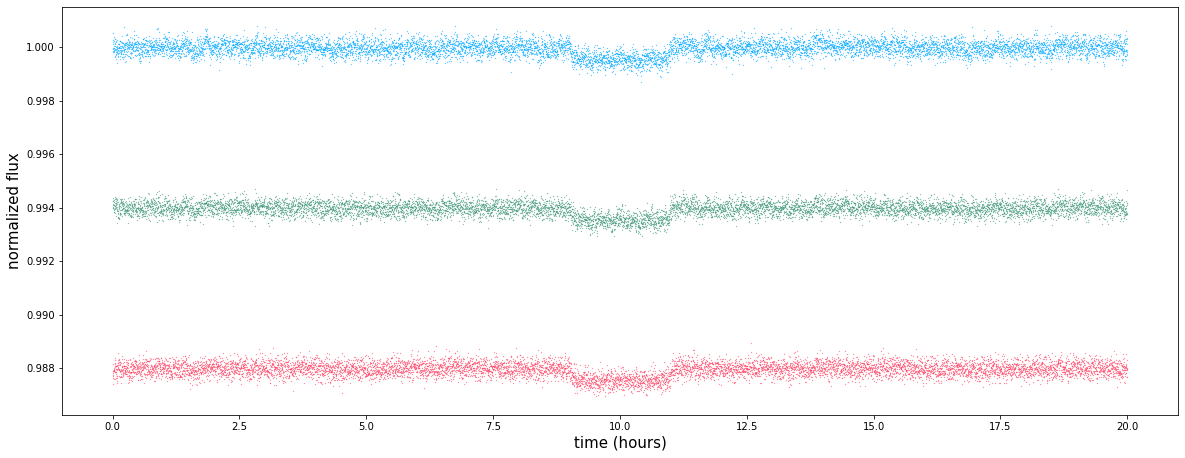

In [662]:
pl.figure(figsize=(20, 7.5))
for i in range(len(inds)-1):
    pl.plot(t/(60*60), 
            (lcs[:, i]/np.mean(lcs[:, i]) - 0.006 * i + 
             moon+planet), '.', alpha=1, color=colors[2-i], ms=0.5)
pl.ylabel("normalized flux", fontsize=15)
pl.xlabel("time (hours)", fontsize=15)
pl.savefig("/Users/tgordon/Desktop/multiflux.pdf")

In [663]:
data = lcs + np.mean(lcs, axis=0)*moon[:, None]
data = np.append(data, t[:, None], axis=1)
np.savetxt('K22b.dat', data)

In [652]:
np.mean(lcs, axis=0)

array([23371774.05467366, 25416503.0258379 , 22852416.47028973])